## Packages required

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch_geometric.datasets import KarateClub
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

     |████████████████████████████████| 2.6MB 9.6MB/s 
     |████████████████████████████████| 1.5MB 9.7MB/s 
     |████████████████████████████████| 215kB 11.0MB/s 
     |████████████████████████████████| 235kB 22.1MB/s 
     |████████████████████████████████| 2.2MB 23.8MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 


## Utility functions

In [ ]:
def visualize_graph(G, color, size=300, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2", node_size = size)
    plt.show()
    
def visualize_tsne(out, color, size=30, epoch=None, loss = None):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()
    
def visualize_pca(out, color, size=30, epoch=None, loss=None):
    h = PCA(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(h[:, 0], h[:, 1], s=size, c=color, cmap="Set2")    
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()
    
def delete_undirected_edges(edge_index, p):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    edges = random.sample(edges, round(n*(1-p)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1],x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()

def add_undirected_edges(edge_index, edge_num, node_total = 2708):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    while len(edges) - n < edge_num:
        edges.add(frozenset(random.sample(range(node_total), 2)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1],x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()

def dataset_print(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')
    
def data_print(data):
    print(data)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def timethis(func):
    @wraps(func) 
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Time to run function '{}': {:.2f} seconds".format(func.__name__, end-start)) 
        return result
    return wrapper
    

## Training functions

In [ ]:
mask = collections.namedtuple('mask', ('train', 'test')) #tuple to store train mask, test mask

def train_one_epoch(model, criterion, optimizer, x, y, train_mask = None): #x is a dictionary
    model.train()
    out = model(**x)
    loss = criterion(out, y) if train_mask is None else criterion(out[train_mask], y[train_mask])
    _, predicted = torch.max(out.detach(),1)
    
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        if train_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item()/length
        else:
            length = len(y[train_mask])
            accuracy = (predicted[train_mask] == y[train_mask].detach()).sum().item()/length
    
    return out, loss.item(), accuracy

def test(model, x, y, test_mask = None): #x is a dictionary
    model.eval()
    with torch.no_grad():
        out = model(**x)
        _, predicted = torch.max(out, 1)
        if test_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item()/length
        else:
            length = len(y[test_mask])
            accuracy = (predicted[test_mask] == y[test_mask]).sum().item()/length
    return accuracy
    
def plot_acc(train_acc, test_acc=None, xaxis = 'epochs', yaxis = 'accuracy', title = 'Accuracy plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    if test_acc is not None:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.plot(np.arange(len(test_acc)), test_acc, color='blue')
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
    else: 
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.legend(['train accuracy'], loc='upper right')
    plt.title(title)
    plt.tight_layout()
    plt.show() #show train_acc and test_acc together
    
def plot_loss(loss, xaxis = 'epochs', yaxis = 'loss', title = 'Loss plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.plot(np.arange(len(loss)), loss, color='black')
    plt.title(title)
    plt.tight_layout()
    plt.show()

@timethis
def train(epochs, model, criterion, optimizer, x, y, m = mask(None, None), 
          plotting = True, scatter_size = 30, plotting_freq = 5, dim_reduction = 'pca'):
    dim_reduction_dict = {'pca': visualize_pca, 'tsne': visualize_tsne}
    train_acc_list = []
    test_acc_list = []
    loss_list = []
    for epoch in range(epochs):
        out, loss, train_acc = train_one_epoch(model, criterion, optimizer, x, y, m.train)
        model.eval()
        test_acc = test(model, x, y, m.test)
        train_acc_list.append(train_acc)
        loss_list.append(loss)
        test_acc_list.append(test_acc)
        if plotting:
            if epoch % plotting_freq == 0:
                clear_output(wait=True)
                dim_reduction_dict[dim_reduction](out, color=y, size = scatter_size, epoch=epoch, loss = loss)
    if plotting:
        if m == mask(None, None):
            plot_acc(train_acc_list)
        else:
            plot_acc(train_acc_list, test_acc_list)
        plot_loss(loss_list)
    return train_acc_list, test_acc_list, loss_list

## Exploring Karate Club dataset

In [ ]:
from torch_geometric.datasets import KarateClub

karateset = KarateClub()
dataset_print(karateset)
print()
print('Information about the graph in the dataset:')
print()
karate=karateset[0] #a single graph
data_print(karate)

In [ ]:
G = to_networkx(karate, to_undirected=True)
visualize_graph(G, color=karate.y) 

Visualizing the final output layer of the GCN on the Karate dataset

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.linear = Linear(2, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh() #shape: (34,2)
        out = self.linear(h) #shape: (34,4)
        return out

model = GCN(karateset.num_features, karateset.num_classes)
outt = model(karate.x, karate.edge_index)
visualize_pca(outt, color=karate.y)

Visualizing how the final output layer changes when training is in progress

In [ ]:
model = GCN(karateset.num_features, karateset.num_classes)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
train_acc_list, test_acc_list, loss_list = train(400, model, criterion, optimizer,
                                                 x={'x': karate.x, 'edge_index': karate.edge_index}, y = karate.y)

## Cora Dataset

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

coraset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
dataset_print(coraset)
cora = coraset[0]
print()
data_print(cora)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


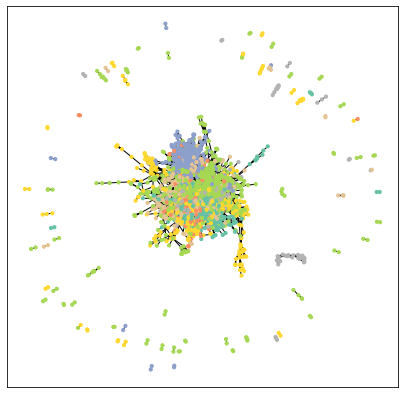

In [ ]:
G = to_networkx(cora, to_undirected=True)
visualize_graph(G, color=cora.y, size=10)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        out = self.lin2(x)
        return out

linear_model = MLP(hidden_channels=16, num_features = coraset.num_features, num_classes=coraset.num_classes)
visualize_tsne(linear_model(cora.x), color=cora.y, size=30)

In [ ]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list = train(300, linear_model, criterion, optimizer, 
                                                 x={'x': cora.x}, y=cora.y, m=mask(cora.train_mask, cora.test_mask),
                                                scatter_size=30)

In [ ]:
visualize_tsne(linear_model(cora.x), color=cora.y, size=30)

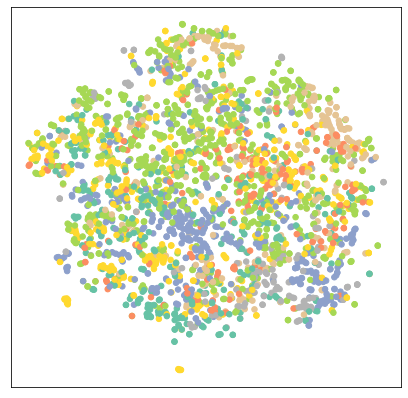

In [ ]:
class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(GCN2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        h = F.dropout(x, p=0.2, training=self.training)
        out = self.conv2(h, edge_index)
        return out

GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
visualize_tsne(GCN2_model(cora.x, cora.edge_index), color=cora.y, size=30)

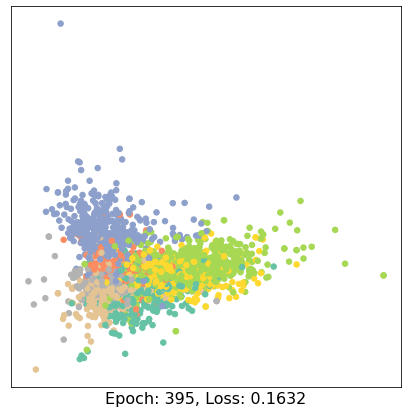

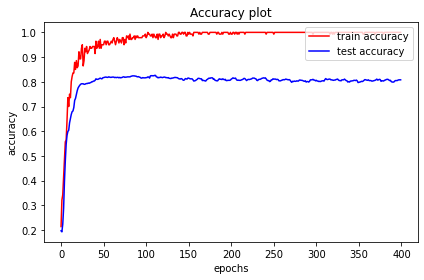

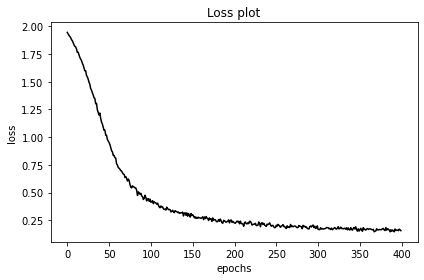

Time to run function 'train': 26.18 seconds


In [ ]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
train_acc_list, test_acc_list, loss_list = train(400, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y,
                                                scatter_size = 30)

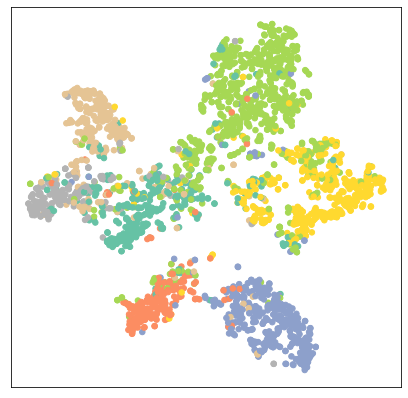

In [ ]:
visualize_tsne(GCN2_model(cora.x, cora.edge_index), color=cora.y, size=30)

## Delete edges

I remove 5% to 95% of the edges randomly and observe how the accuracy changes

Time to run function 'train': 6.14 seconds
Time to run function 'train': 5.96 seconds
Time to run function 'train': 5.76 seconds
Time to run function 'train': 5.65 seconds
Time to run function 'train': 5.55 seconds
Time to run function 'train': 5.45 seconds
Time to run function 'train': 5.43 seconds
Time to run function 'train': 5.17 seconds
Time to run function 'train': 5.10 seconds
Time to run function 'train': 4.98 seconds
Time to run function 'train': 4.86 seconds
Time to run function 'train': 4.78 seconds
Time to run function 'train': 4.70 seconds
Time to run function 'train': 4.60 seconds
Time to run function 'train': 4.47 seconds
Time to run function 'train': 4.37 seconds
Time to run function 'train': 4.31 seconds
Time to run function 'train': 4.04 seconds
Time to run function 'train': 4.12 seconds


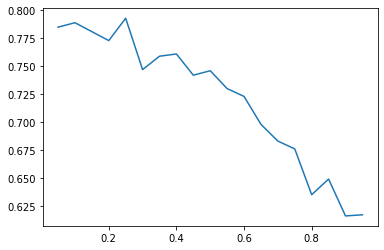

In [ ]:
p_list = np.arange(0.05, 1, 0.05)
num_epochs = 200
acc_list = []
for p in p_list:
    GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
    edges = delete_undirected_edges(cora.edge_index, p)
    _, test_acc_list, _ = train(num_epochs, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': edges}, y = cora.y,
                                                plotting = False)
    acc_list.append(test_acc_list[-1])

plt.plot(p_list, acc_list)

## Add edges

I add 0 to 20000 random edges to the graph to see how accuracy changes

Time to run function 'train': 6.20 seconds
Time to run function 'train': 6.45 seconds
Time to run function 'train': 6.88 seconds
Time to run function 'train': 7.40 seconds
Time to run function 'train': 7.70 seconds
Time to run function 'train': 8.08 seconds
Time to run function 'train': 8.50 seconds
Time to run function 'train': 8.89 seconds
Time to run function 'train': 9.16 seconds
Time to run function 'train': 9.67 seconds
Time to run function 'train': 10.12 seconds
Time to run function 'train': 10.57 seconds
Time to run function 'train': 10.96 seconds
Time to run function 'train': 11.54 seconds
Time to run function 'train': 11.80 seconds
Time to run function 'train': 12.17 seconds
Time to run function 'train': 12.69 seconds
Time to run function 'train': 12.96 seconds
Time to run function 'train': 13.39 seconds
Time to run function 'train': 13.70 seconds


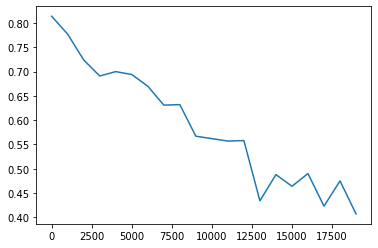

In [ ]:
n_list = range(0, 20000, 1000)
acc_list = []
for n in n_list:
    GCN2_model = GCN2(16, coraset.num_features, coraset.num_classes)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN2_model.parameters(), lr=0.01, weight_decay=5e-4)
    edges = add_undirected_edges(cora.edge_index, n)
    _, test_acc_list, _ = train(num_epochs, GCN2_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': edges}, y = cora.y,
                                                plotting = False)
    acc_list.append(test_acc_list[-1])
    
plt.plot(n_list, acc_list)

## Accuracy vs Depth

In [ ]:
class GCN_depth(torch.nn.Module):
    def __init__(self, hidden_dim, num_features, num_classes, num_layers):
        super(GCN_depth, self).__init__()
        torch.manual_seed(12345)

        self.input_dim = num_features
        self.hidden_dim = hidden_dim
        self.label_dim = num_classes
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(self.input_dim, self.hidden_dim))
        for layer in range(self.num_layers - 2):
            self.convs.append(GCNConv(self.hidden_dim, self.hidden_dim))
        self.final_conv = GCNConv(self.hidden_dim, self.label_dim)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=0.2, training=self.training)
        out = self.final_conv(x, edge_index)
        return out

GCN_depth_model = GCN_depth(16, coraset.num_features, coraset.num_classes, 4)
visualize_tsne(GCN_depth_model(cora.x, cora.edge_index), color=cora.y, size=30)

In [ ]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(GCN_depth_model.parameters(), lr=0.01, weight_decay=5e-4)
train_acc_list, test_acc_list, loss_list = train(400, GCN_depth_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y,
                                                scatter_size = 30)

In [ ]:
layers_list = np.arange(3, 17)
num_epochs = 300
train_accs = []
test_accs = []
losses = []

for num_layers in layers_list:
    GCN_depth_model = GCN_depth(16, coraset.num_features, coraset.num_classes, num_layers)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN_depth_model.parameters(), lr=0.01, weight_decay=5e-4)
    train_acc_list, test_acc_list, loss_list = train(num_epochs, GCN_depth_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y,
                                                plotting = False)
    train_accs.append(train_acc_list[-1])
    test_accs.append(test_acc_list[-1])
    losses.append(loss_list[-1])

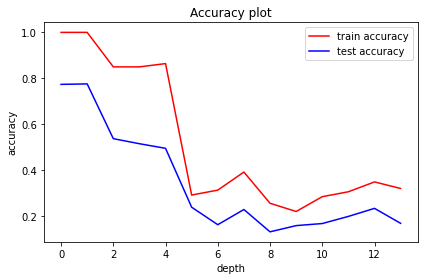

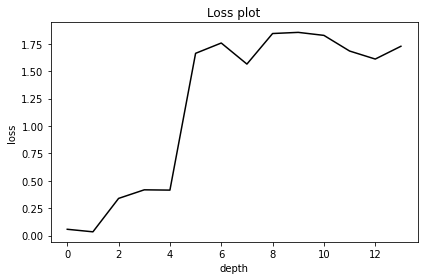

In [ ]:
plot_acc(train_accs, test_accs, xaxis = 'depth')
plt.show()
plot_loss(losses, xaxis = 'depth')
plt.show()

## Accuracy vs Depth and hidden channels

Time to run function 'train': 6.59 seconds
Time to run function 'train': 6.91 seconds
Time to run function 'train': 7.96 seconds
Time to run function 'train': 13.61 seconds
Time to run function 'train': 24.33 seconds


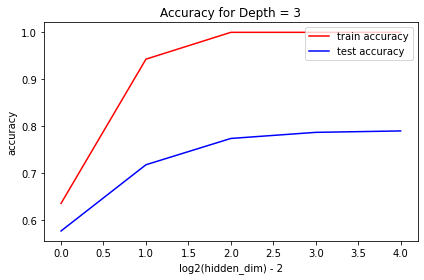

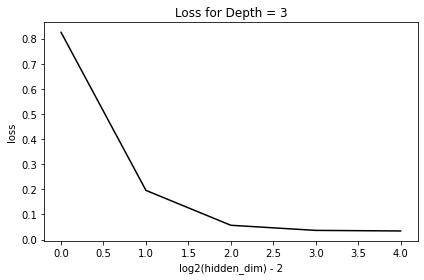

Time to run function 'train': 7.94 seconds
Time to run function 'train': 8.48 seconds
Time to run function 'train': 9.85 seconds
Time to run function 'train': 17.25 seconds
Time to run function 'train': 32.15 seconds


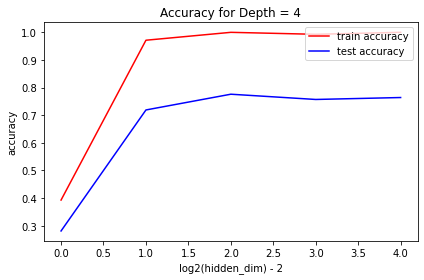

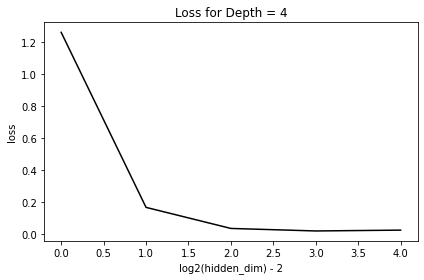

Time to run function 'train': 10.81 seconds
Time to run function 'train': 11.94 seconds
Time to run function 'train': 14.10 seconds
Time to run function 'train': 25.59 seconds
Time to run function 'train': 47.16 seconds


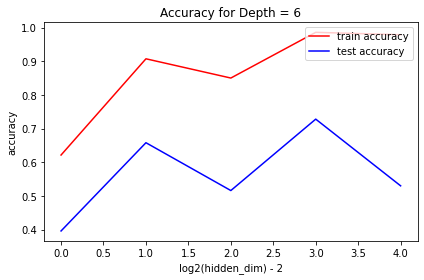

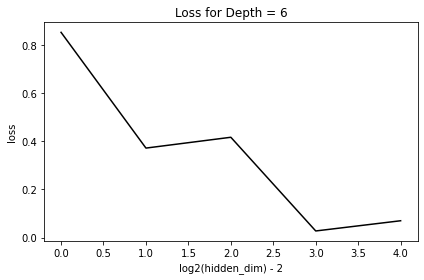

Time to run function 'train': 17.17 seconds
Time to run function 'train': 18.99 seconds
Time to run function 'train': 22.32 seconds
Time to run function 'train': 41.95 seconds
Time to run function 'train': 79.10 seconds


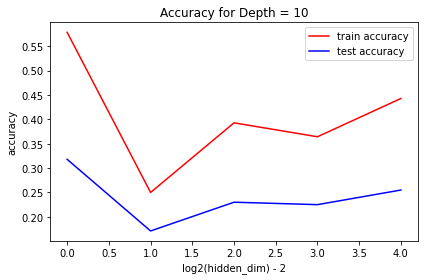

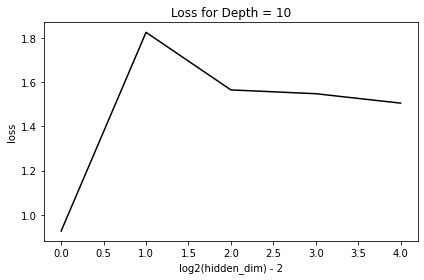

Time to run function 'train': 27.00 seconds
Time to run function 'train': 32.16 seconds
Time to run function 'train': 37.18 seconds
Time to run function 'train': 74.97 seconds
Time to run function 'train': 147.11 seconds


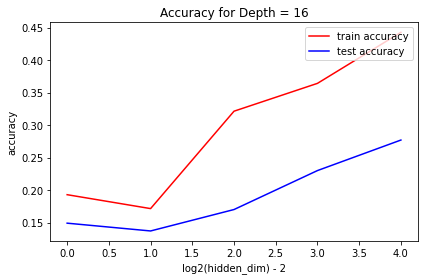

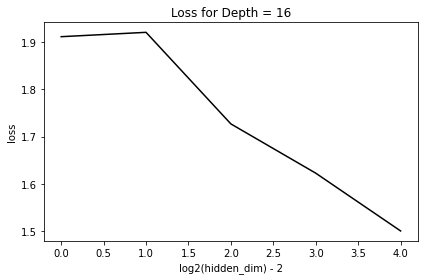

In [ ]:
layers_list = [3, 4, 6, 10, 16]
hidden_list = [4, 8, 16, 32, 64]

num_epochs = 300

for num_layers in layers_list:
  train_accs = []
  test_accs = []
  losses = []

  for num_cells in hidden_list:
      GCN_depth_model = GCN_depth(num_cells, coraset.num_features, coraset.num_classes, num_layers)
      criterion = torch.nn.CrossEntropyLoss() 
      optimizer = torch.optim.Adam(GCN_depth_model.parameters(), lr=0.01, weight_decay=5e-4)
      train_acc_list, test_acc_list, loss_list = train(num_epochs, GCN_depth_model, criterion, optimizer, 
                                                   m=mask(cora.train_mask, cora.test_mask), 
                                                   x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y, plotting = False)
      train_accs.append(train_acc_list[-1])
      test_accs.append(test_acc_list[-1])
      losses.append(loss_list[-1])

  plot_acc(train_accs, test_accs, xaxis = 'log2(hidden_dim) - 2', yaxis='accuracy', title = 'Accuracy for Depth = ' + str(num_layers))
  plt.show()
  plot_loss(losses, xaxis = 'log2(hidden_dim) - 2', yaxis='loss', title = 'Loss for Depth = ' + str(num_layers))
  plt.show()

## Accuracy vs non-linearity removal

In [ ]:
class GCN_activ(torch.nn.Module):
    def __init__(self, hidden_dim, num_features, num_classes, num_layers, num_activ):
        super(GCN_activ, self).__init__()
        #torch.manual_seed(12345)

        self.input_dim = num_features
        self.hidden_dim = hidden_dim
        self.label_dim = num_classes
        self.num_layers = num_layers
        self.num_activ = num_activ
        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(self.input_dim, self.hidden_dim))
        for layer in range(self.num_layers - 2):
            self.convs.append(GCNConv(self.hidden_dim, self.hidden_dim))
        self.final_conv = GCNConv(self.hidden_dim, self.label_dim)

    def forward(self, x, edge_index):
        activ = 0
        for conv in self.convs:
            x = conv(x, edge_index)
            if self.num_activ < activ:
              x = x.relu()
              activ = activ + 1
            x = F.dropout(x, p=0.2, training=self.training)
        out = self.final_conv(x, edge_index)
        return out

Time to run function 'train': 12.07 seconds
Time to run function 'train': 12.32 seconds
Time to run function 'train': 12.07 seconds
Time to run function 'train': 11.89 seconds


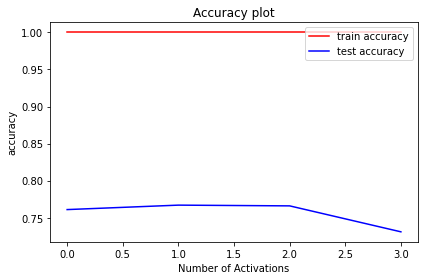

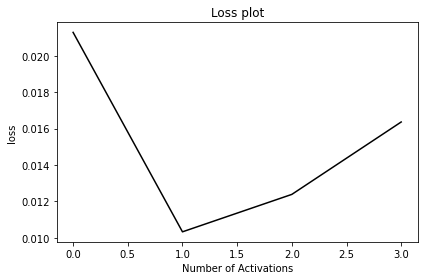

In [ ]:
num_layers = 4
activ_list = np.arange(0, num_layers)
num_epochs = 300
train_accs = []
test_accs = []
losses = []

for num_activ in activ_list:
    GCN_activ_model = GCN_activ(16, coraset.num_features, coraset.num_classes, num_layers, num_activ)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(GCN_activ_model.parameters(), lr=0.01, weight_decay=5e-4)
    train_acc_list, test_acc_list, loss_list = train(num_epochs, GCN_activ_model, criterion, optimizer, 
                                                 m=mask(cora.train_mask, cora.test_mask), 
                                                 x={'x': cora.x, 'edge_index': cora.edge_index}, y = cora.y, plotting = False)
    train_accs.append(train_acc_list[-1])
    test_accs.append(test_acc_list[-1])
    losses.append(loss_list[-1])


plot_acc(train_accs, test_accs, xaxis = 'Number of Activations')
plt.show()
plot_loss(losses, xaxis = 'Number of Activations')
plt.show()